# Lab 4

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import scipy.signal
import seaborn as sns

from IPython.display import display, Math
from functools import partial
from scipy import optimize, stats
from scipy.stats.distributions import gamma, expon, norm, chi2
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error

from fedot.core.data.data import InputData
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.data.data_split import train_test_data_setup

In [2]:
path_to_file = input()
source_df = pd.read_csv(path_to_file)

# df = source_df[[
#     'hospital_beds_per_thousand', 'people_vaccinated', 'total_tests', # predictors
#     'new_cases', 'excess_mortality_cumulative_per_million' # targets
# ]].copy().dropna()

df = source_df[[
    'date',
    
    'hospital_beds_per_thousand', 'people_vaccinated', 'total_tests', # predictors
    'new_cases', 'excess_mortality_cumulative_per_million' # targets
]].copy().dropna()

In [3]:
pd.set_option('display.max_columns', None)
source_df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.122,0.122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.122,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.122,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.122,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.122,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231404,ZWE,Africa,Zimbabwe,2022-10-26,257893.0,0.0,0.0,5606.0,0.0,0.0,15801.745,0.000,0.0,343.494,0.0,0.0,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN
231405,ZWE,Africa,Zimbabwe,2022-10-27,257893.0,0.0,0.0,5606.0,0.0,0.0,15801.745,0.000,0.0,343.494,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,16320539.0,NaN,NaN,NaN,NaN
231406,ZWE,Africa,Zimba

## 2

In [4]:
from datetime import datetime

# already daily
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

In [5]:
hospital_beds_per_thousand_daily = df.groupby('date', as_index=False).agg({'hospital_beds_per_thousand': 'sum'})
hospital_beds_per_thousand_daily = hospital_beds_per_thousand_daily.sort_values('date')

In [6]:
people_vaccinated_daily = df.groupby('date', as_index=False).agg({'people_vaccinated': 'sum'})
people_vaccinated_daily = people_vaccinated_daily.sort_values('date')

In [7]:
total_tests_daily = df.groupby('date', as_index=False).agg({'total_tests': 'sum'})
total_tests_daily = total_tests_daily.sort_values('date')

In [8]:
new_cases_daily = df.groupby('date', as_index=False).agg({'new_cases': 'sum'})
new_cases_daily = new_cases_daily.sort_values('date')

In [9]:
emcpm_daily = df.groupby('date', as_index=False).agg({'excess_mortality_cumulative_per_million': 'sum'})
emcpm_daily = emcpm_daily.sort_values('date')

In [10]:
merged = pd.merge(
    hospital_beds_per_thousand_daily,
    people_vaccinated_daily
)

merged = pd.merge(
    merged,
    total_tests_daily
)

merged = pd.merge(
    merged,
    new_cases_daily
)

merged = pd.merge(
    merged,
    emcpm_daily
)

merged

,date,hospital_beds_per_thousand,people_vaccinated,total_tests,new_cases,excess_mortality_cumulative_per_million
0,2020-12-13,2.770,32129.0,2.272770e+08,190625.0,1178.313352
1,2020-12-20,19.930,1221321.0,2.764065e+08,197903.0,1844.320544
2,2020-12-27,70.330,3528262.0,4.051998e+08,194182.0,13436.606172
3,2020-12-31,7.960,45809.0,7.501389e+06,13208.0,853.126320
4,2021-01-03,91.520,8026842.0,4.355922e+08,270335.0,15289.668294
...,...,...,...,...,...,...
90,2022-05-29,109.389,593522418.0,2.323146e+09,84307.0,60767.269244
91,2022-05-31,20.010,192257954.0,1.472748e+08,27210.0,3188.788449
92,2022-06-05,122.069,606519956.0,2.367713e+09,101789.0,66985.248061
93,2022-06-12,102.625,575811202.0,2.283280e+09,65042.0,52413.656082


In [11]:
# predictors
predictors = ['hospital_beds_per_thousand', 'people_vaccinated', 'total_tests']
# beds = df['hospital_beds_per_thousand'].dropna()
# vac = df['people_vaccinated'].dropna()
# tests = df['total_tests'].dropna()

# targets
targets = ['new_cases', 'excess_mortality_cumulative_per_million']
# cases = df['new_cases'].dropna()
# emcpm = df['excess_mortality_cumulative_per_million'].dropna()

all_vars = predictors + targets

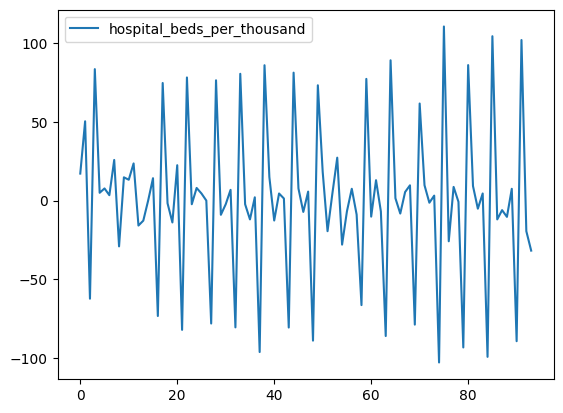

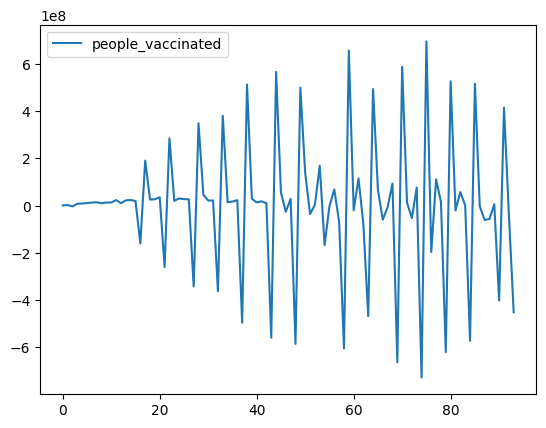

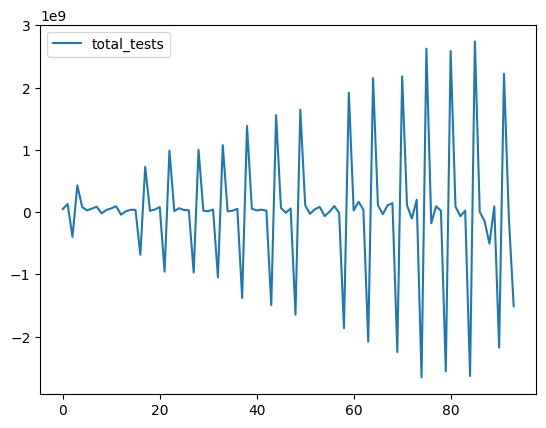

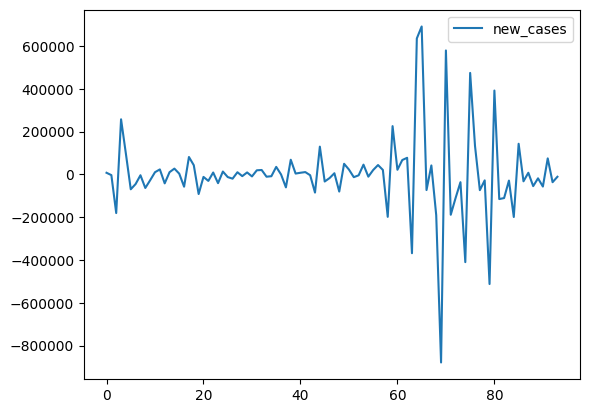

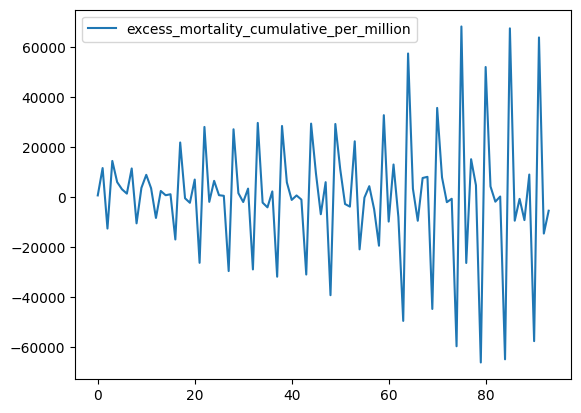

In [12]:
# trend subtraction using differences
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
        
    return pd.Series(diff)

diff_df = pd.DataFrame()

for var in all_vars:
    diff_df[var] = difference(merged[var], interval=1)
    diff_df.plot(y=var)

diff_df.fillna(value=0, inplace=True)

# diff = difference(dataset=merged['hospital_beds_per_thousand'], interval=1)

# plt.plot(diff)
# plt.show()

In [13]:
# find the trend
def trendline(data, order=9):
    # polynomial trend
    trend = np.polyfit(data.index.values, list(data), order)
    return np.poly1d(trend)(data.index.values)

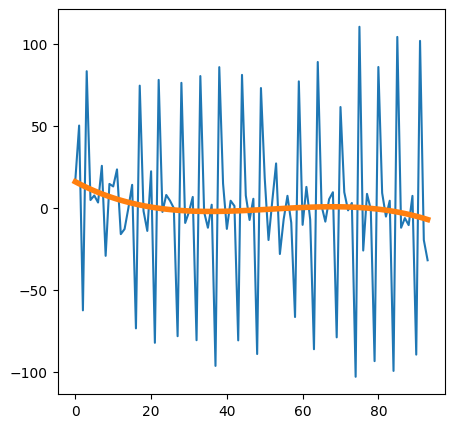

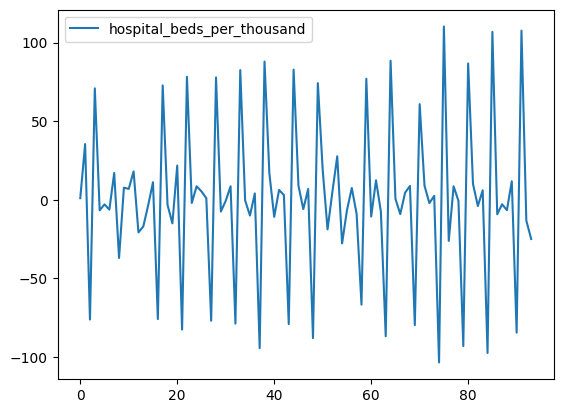

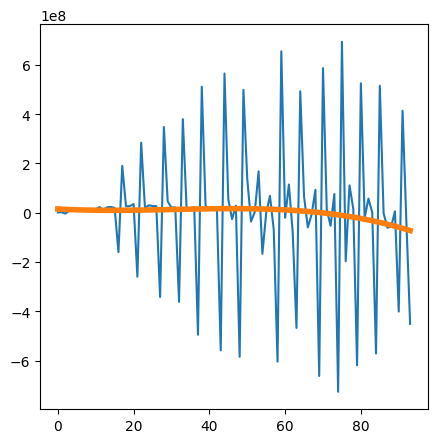

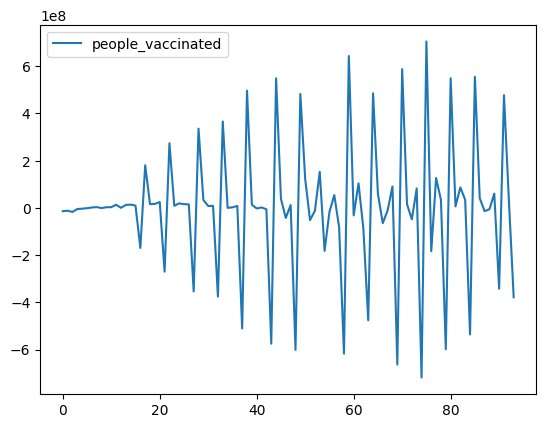

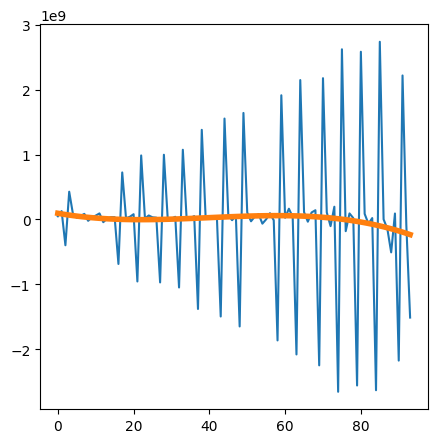

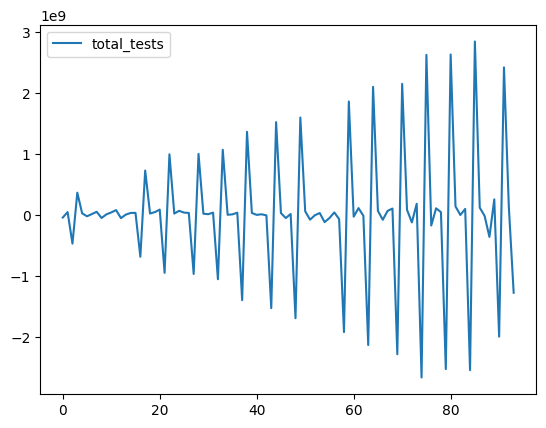

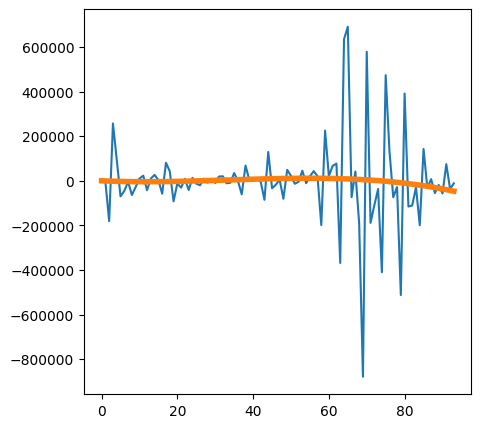

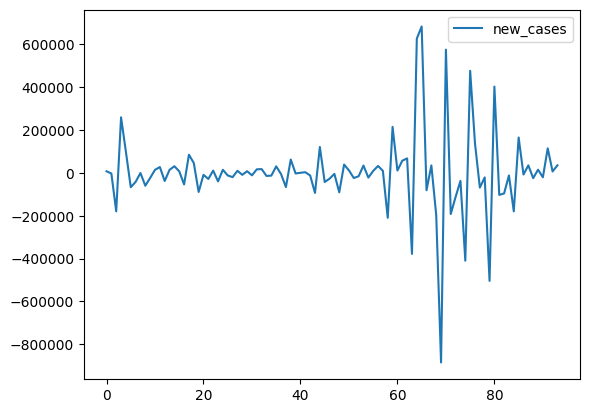

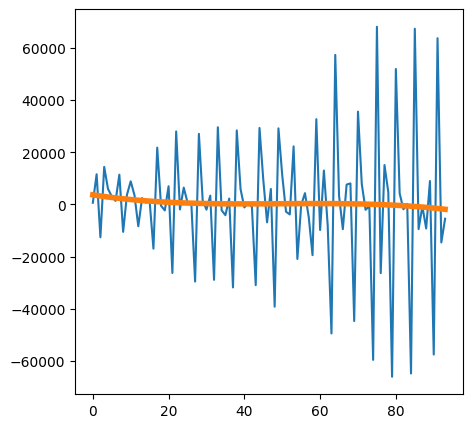

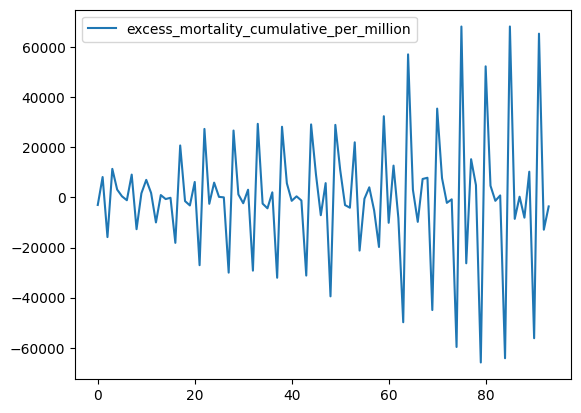

In [14]:
trendless_data = pd.DataFrame()

for var in all_vars:
    trend = trendline(diff_df[var], 3)
    plt.figure(figsize=(5, 5))
    plt.plot(diff_df[var])
    plt.plot(trend, linewidth=4)
    plt.show()
    trendless_data[var] = diff_df[var] - trend
    trendless_data.plot(y=var)

## 3

<AxesSubplot: >

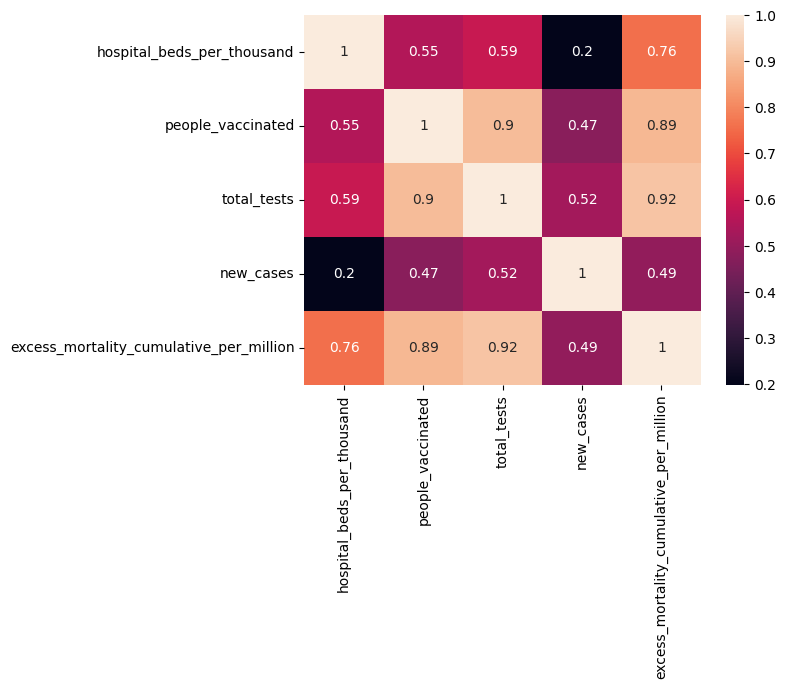

In [15]:
import seaborn as sns
sns.heatmap(merged.corr(method='pearson'), annot=True)

<AxesSubplot: >

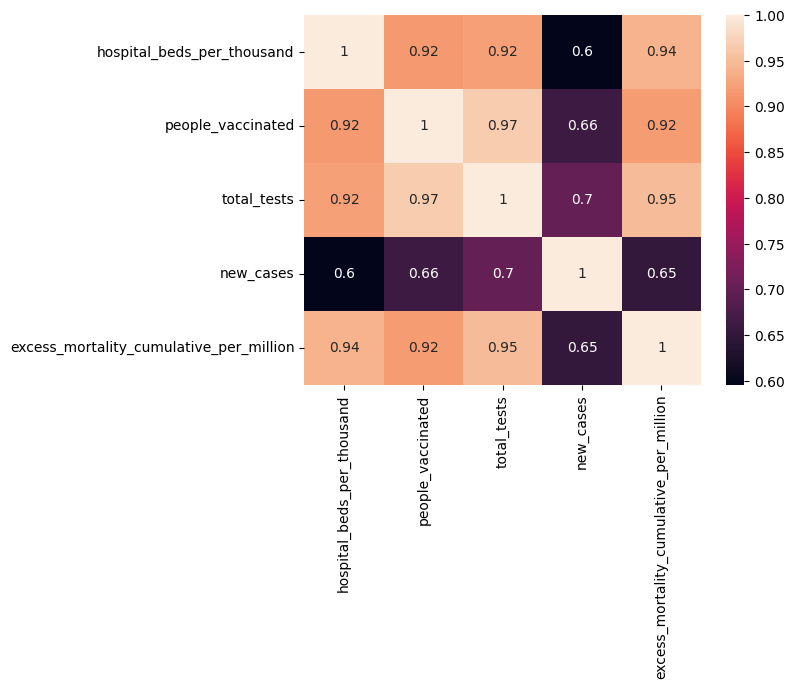

In [16]:
sns.heatmap(diff_df.corr(method='pearson'), annot=True)

<AxesSubplot: >

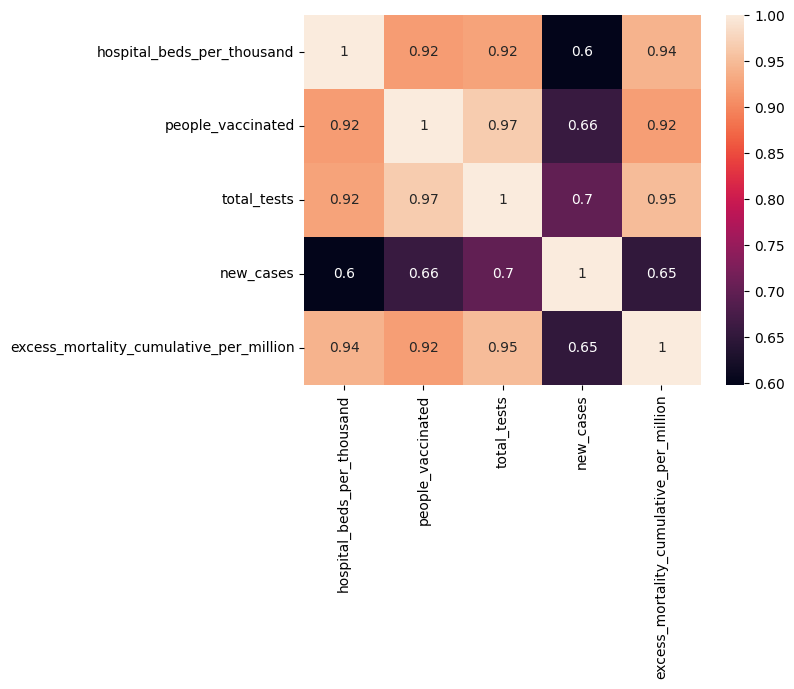

In [17]:
sns.heatmap(trendless_data.corr(method='pearson'), annot=True)

## 4

In [18]:
filter1 = lambda x: x.rolling(window=24, win_type='gaussian', min_periods=1, center=True).mean(std=1)
filter2 = lambda x: x.rolling(window=12, win_type='hamming', min_periods=1, center=True).mean()

def plot_target_filtered(series):
    plt.plot(series, label='Truth')
    plt.plot(filter1(series), label='Filter 1')
    plt.plot(filter2(series), label='Filter 2')
    plt.legend()
    plt.show()

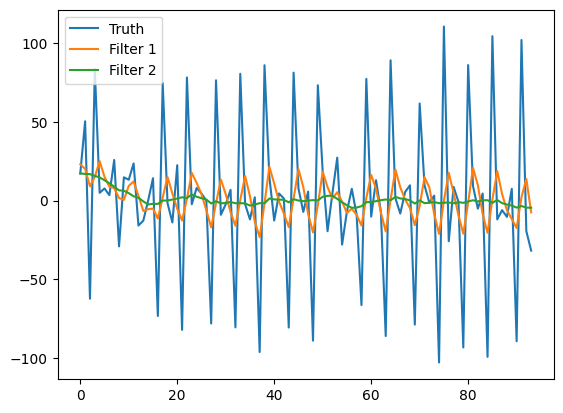

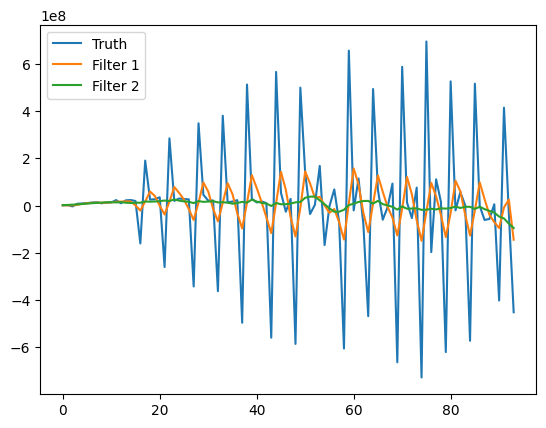

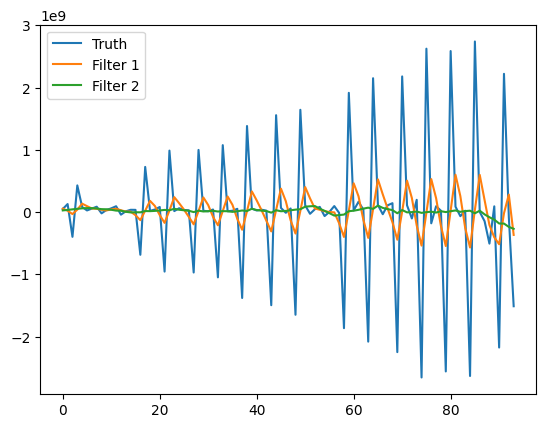

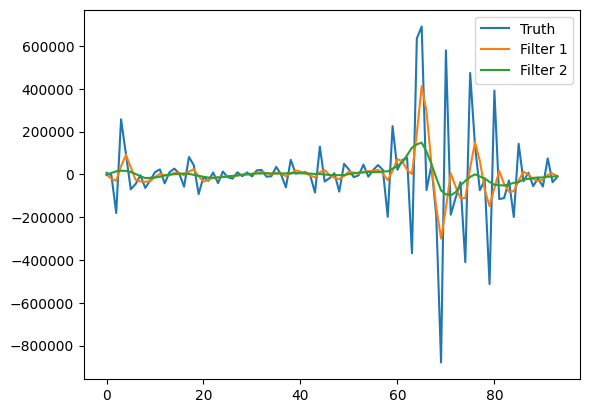

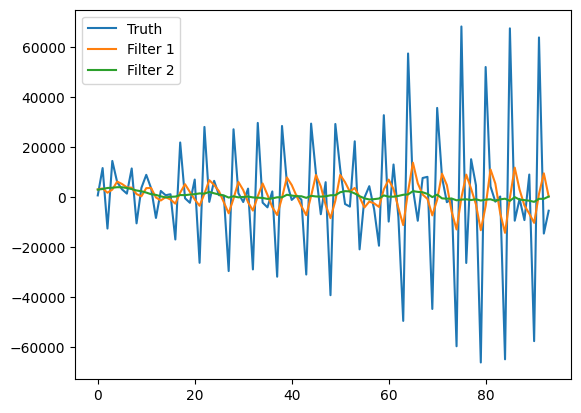

In [19]:
for var in all_vars:
    plot_target_filtered(diff_df[var])

## 5

In [20]:
def plot_spectral_density(data, var):
    (f, S) = scipy.signal.periodogram(data, scaling='density')
    (f_1, S_1) = scipy.signal.periodogram(filter1(data), scaling='density')
    (f_2, S_2) = scipy.signal.periodogram(filter2(data), scaling='density')
    
    plt.semilogy(f, S, label='Truth')
    plt.semilogy(f_1, S_1, label='Filter 1')
    plt.semilogy(f_2, S_2, label='Filter 2')
    plt.title('Spectral density for ' + var)
    plt.legend()
    plt.show()

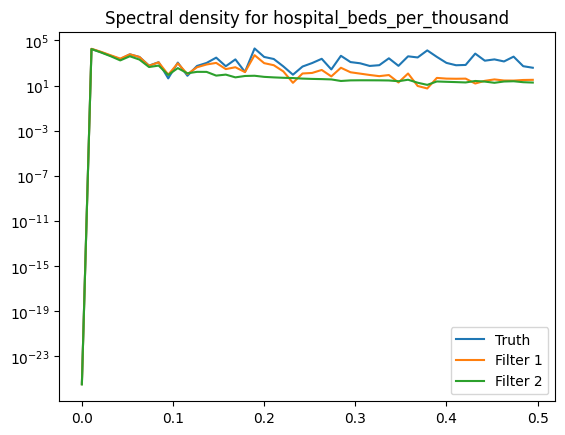

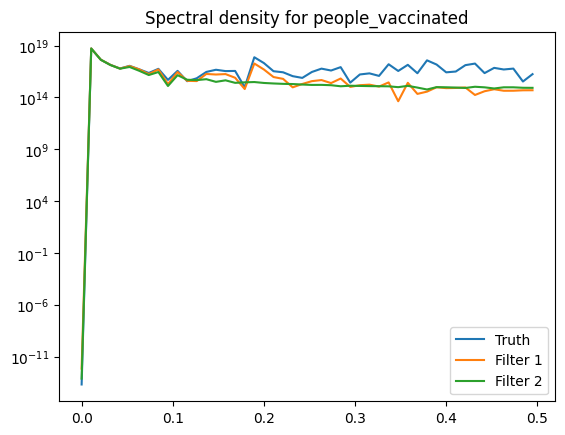

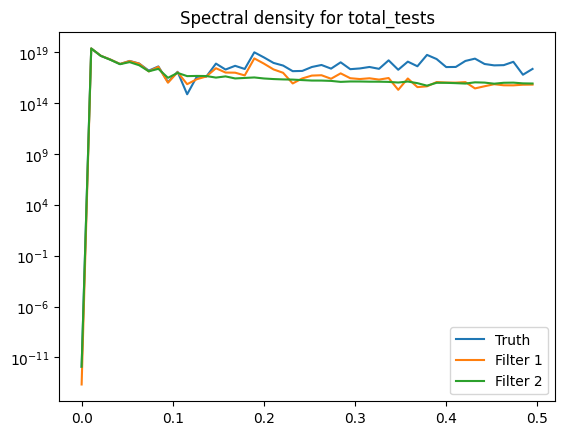

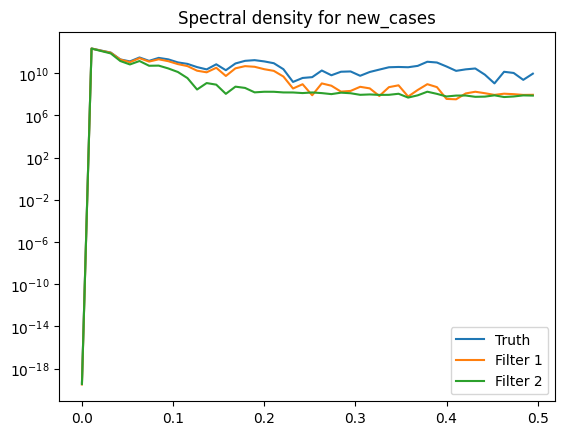

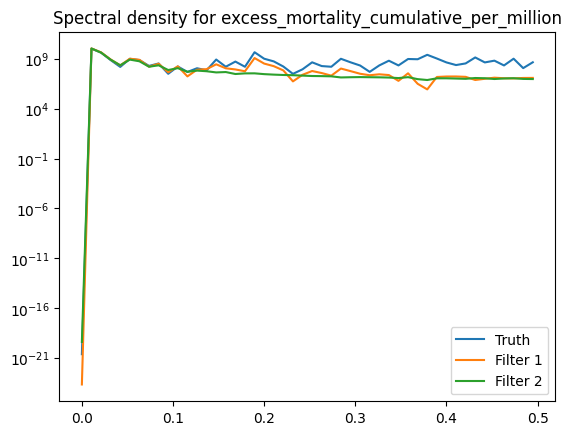

In [21]:
for var in all_vars:
    plot_spectral_density(merged[var], var)

## 6
### Non-Filtered Data

In [41]:
time_series = np.array(merged['new_cases'])

task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=15))

input_data = InputData(idx=np.arange(0, len(time_series)),
                       features=time_series, target=time_series,
                       task=task, data_type=DataTypesEnum.ts)

train, test = train_test_data_setup(input_data)

pipeline = Pipeline(PrimaryNode('arima'))
pipeline = pipeline.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                        loss_params=None, input_data=train,
                                        iterations=100, timeout=5,
                                        cv_folds=2, validation_blocks=2)

Start pipeline tuning
Hyperparameters optimization start
100%|██████████| 100/100 [01:09<00:00,  1.43trial/s, best loss: 219856.97436192667]
Hyperparameters optimization finished
Return tuned pipeline due to the fact that obtained metric 219856.974 equal or smaller than initial (+ 5% deviation) 234023.075
Tuning was finished


Trained operation is not actual because you are using new dataset for training. Parameter use_fitted value changed to False


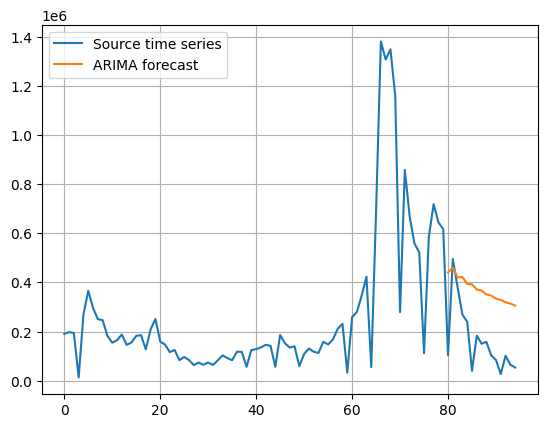

In [42]:
fitted_vals = pipeline.fit(train)
forecast = pipeline.predict(test)

plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(forecast.idx, np.ravel(forecast.predict), label='ARIMA forecast')
plt.grid()
plt.legend()
plt.show()

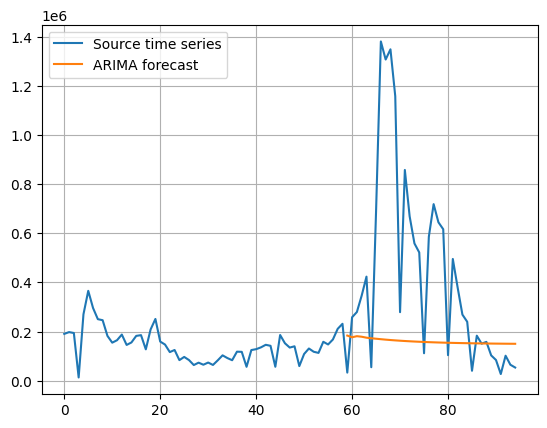

In [25]:
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(forecast.idx, np.ravel(forecast.predict), label='ARIMA forecast')
plt.grid()
plt.legend()
plt.show()

### Filtered Data

In [39]:
time_series = np.array(filter2(merged['new_cases']))

task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=15))

input_data = InputData(idx=np.arange(0, len(time_series)),
                       features=time_series, target=time_series,
                       task=task, data_type=DataTypesEnum.ts)

train, test = train_test_data_setup(input_data)

pipeline = Pipeline(PrimaryNode('arima'))
pipeline = pipeline.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                        loss_params=None, input_data=train,
                                        iterations=100, timeout=5,
                                        cv_folds=2, validation_blocks=2)

Start pipeline tuning
Hyperparameters optimization start
100%|██████████| 100/100 [01:06<00:00,  1.50trial/s, best loss: 213689.61629476896]
Hyperparameters optimization finished
Return tuned pipeline due to the fact that obtained metric 213689.616 equal or smaller than initial (+ 5% deviation) 229336.723
Tuning was finished


Trained operation is not actual because you are using new dataset for training. Parameter use_fitted value changed to False


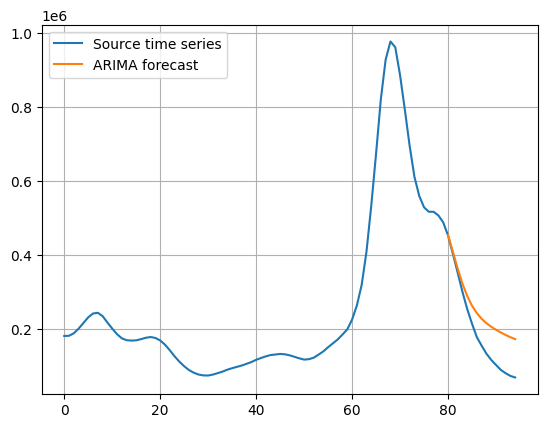

In [40]:
fitted_vals = pipeline.fit(train)
forecast = pipeline.predict(test)

plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(forecast.idx, np.ravel(forecast.predict), label='ARIMA forecast')
plt.grid()
plt.legend()
plt.show()

In [45]:
forecast

OutputData(idx=array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]), features=array([ 190625.,  197903.,  194182.,   13208.,  270335.,  365870.,
        295974.,  250576.,  246330.,  182535.,  154909.,  164860.,
        187874.,  145681.,  155710.,  182439.,  185529.,  127780.,
        208788.,  251406.,  159323.,  147280.,  116593.,  125098.,
         83823.,   96875.,   84102.,   63816.,   73524.,   65107.,
         73970.,   64195.,   83058.,  103310.,   92260.,   83450.,
        118221.,  117556.,   56647.,  124826.,  128422.,  135780.,
        146241.,  142071.,   56719.,  186081.,  152543.,  134961.,
        140118.,   59551.,  108753.,  131109.,  117885.,  113260.,
        158479.,  147582.,  167793.,  211185.,  231734.,   33062.,
        258311.,  279587.,  346408.,  423614.,   54964.,  689949.,
       1380872., 1307453., 1348959., 1158238.,  279021.,  857883.,
        669074.,  558811.,  522146.,  111832.,  585722.,  718844.,
        644868.,  616663.]), task=Ta